In [1]:
import qiskit
import matplotlib.pyplot as plt

{'11': 532, '00': 492}


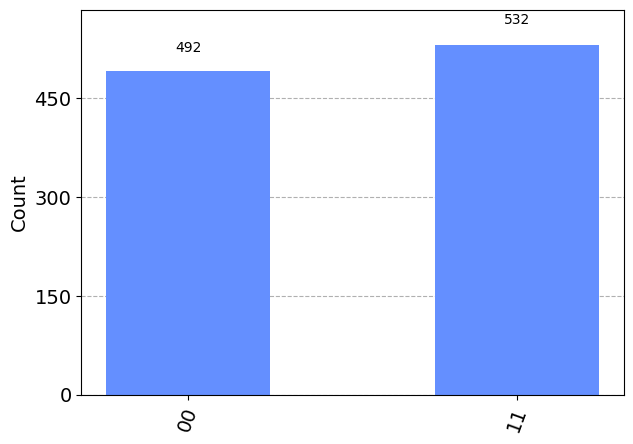

In [2]:
from qiskit import QuantumCircuit
from qiskit import BasicAer, execute
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

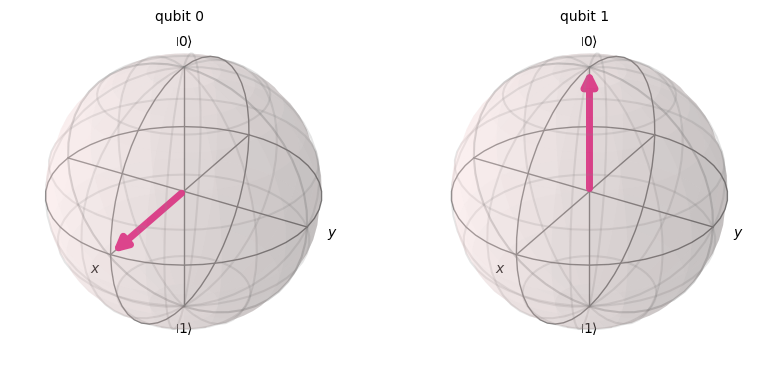

In [3]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

qc = QuantumCircuit(2)
qc.h(0)
qc.draw('mpl')
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)

# Advanced Circuits


## Opaque Gates 

불투명 게이트

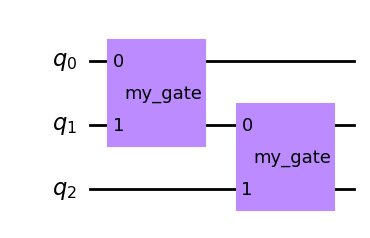

In [6]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

qr = QuantumRegister(3, 'q')
qc = QuantumCircuit(qr)

qc.append(my_gate, [qr[0],qr[1]])
qc.append(my_gate, [qr[1],qr[2]])

qc.draw('mpl')

## Composite Gates  

복합게이트

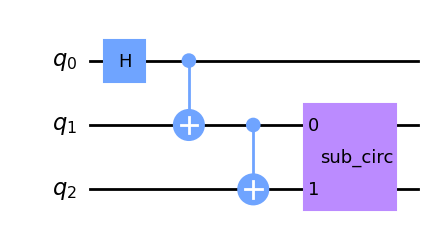

In [7]:
# Build a sub-circuit

sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')

sub_circ.h(sub_q[0]) 
sub_circ.crz(1, sub_q[0], sub_q[1]) 
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1,2,-2,sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0],qr[1])
circ.cx(qr[1],qr[2])
circ.append(sub_inst, [qr[1],qr[2]])

circ.draw('mpl')

Circuits are not immediately decomposed upon conversion 'to_instruction' \
to allow circuit design at higher levels of abstraction. \
When desired, or before compilation, sub-circuits will be decomposed via the 'decompose' method.

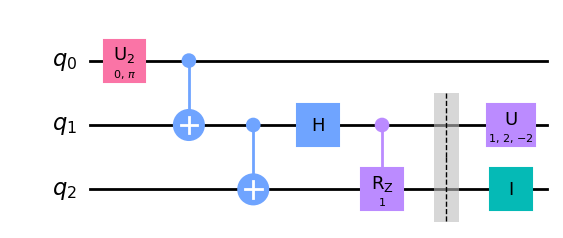

In [8]:
decomposed_circ = circ.decompose()
decomposed_circ.draw('mpl')

## Parameterized Circuits

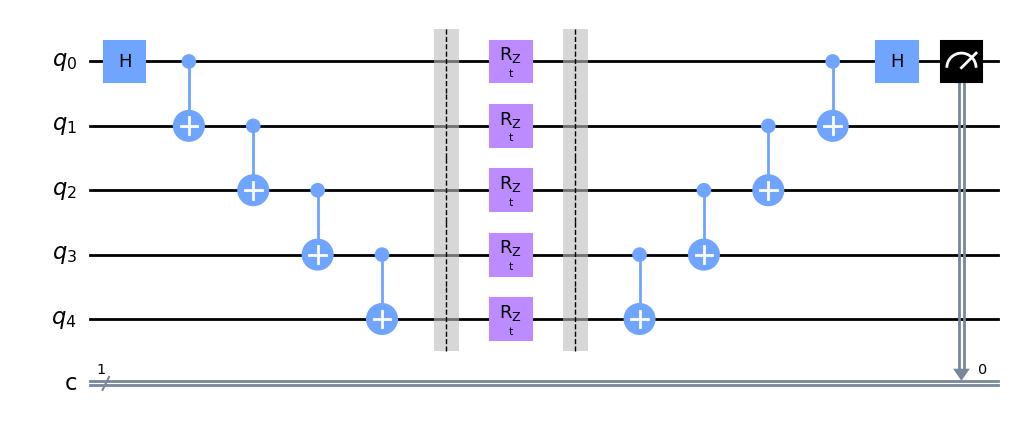

In [9]:
from qiskit.circuit import Parameter

theta = Parameter('t')

n = 5

qc = QuantumCircuit(5,1) # 5 qubit, 1 bit

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i,i+1)

qc.h(0)
qc.measure(0,0)

qc.draw('mpl')

We can inspect the circuit's parameters

In [10]:
print(qc.parameters)

ParameterView([Parameter(t)])


## Binding parameters to values

매개변수에 값 binding

All circuit parameters must be bound before sending the circuit to a backend.\
This can be done as follows: The 'bind_parameters' methos accepts a dictionary mapping 'Parameter's to values,and returns a new circuit with each paramter replaced by its corresponding value.\
Partial binding is supported, in which case the returned circuit will be parameterized by any 'Parameters's that were not mapped to value.

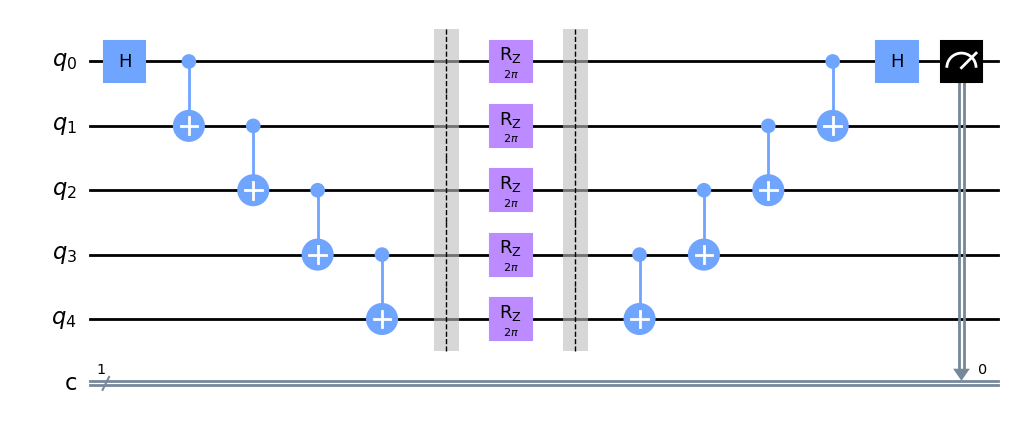

In [11]:
import numpy as np

theta_range = np.linspace(0, 2*np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val}) for theta_val in theta_range]

circuits[-1].draw('mpl')

In [12]:
from qiskit import transpile

backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

In the example circuit, we apply a global Rz(theta) rotation on a five-qubit entangled state, and so expect to see oscillation in qubit-0 at 5 theta

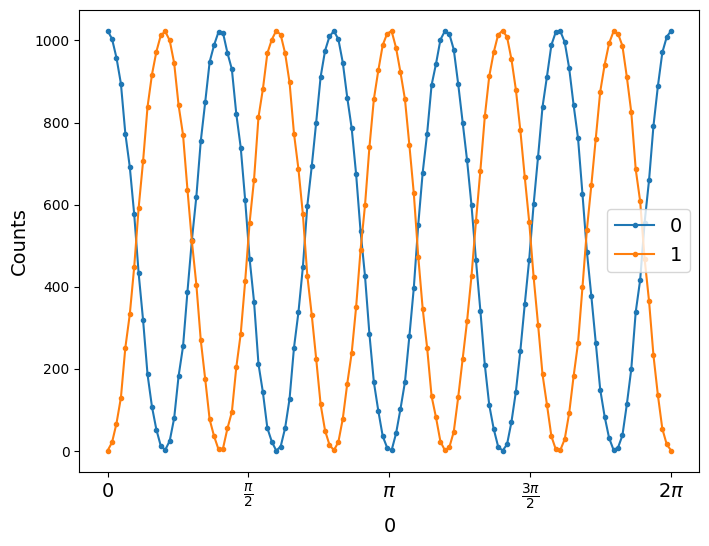

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0',0), counts)), '.-',label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1',0), counts)), '.-',label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('0', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

# Operators

In [14]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from qiskit import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate

## Operator Class
The 'Operator' class is used in Qiskit to represent matrix operators acting on a quantum system.
It has several methods to build composite operators using tensor products of smaller operators, and to compose operators.

### Creating Operators
The easiest way to create an operator object is to initialize it with a matrix given as a list or a Numpy array.\
For example, to create a two-qubit Pauli-XX operator:

In [15]:
XX = Operator([[0,0,0,1],
               [0,0,1,0],
               [0,1,0,0],
               [1,0,0,0]])
XX

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [16]:
XX.data

array([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [17]:
input_dim, output_dim = XX.dim
input_dim, output_dim

(4, 4)

## Using Operators in circuits
Unitary 'Operators' can be directly inserted into a 'QuantumCircuit' using the 'QuantumCircuit.append' method.\
This converts the Operator into a 'UnitaryGate' object, which is added to the circuit.\
If the operator is not unitary, an exception will be raised.\
This can be checked using the 'Operator.is_unitary()' function, which will return 'True' if the operator is unitary and 'False' otherwise.

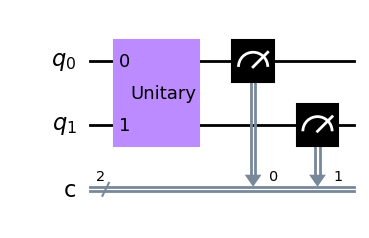

In [18]:
# Create an operator
XX = Operator(Pauli('XX'))

# Add to a circuit

qc = QuantumCircuit(2,2)
qc.append(XX, [0,1])
qc.measure([0,1],[0,1])
qc.draw('mpl')

Note that in the above example we initialize the operator from a Pauli object.\
However, the Pauli object may also be directly inserted into the circuit itself and will be converted into a sequence of single-qubit Pauli gates:

In [19]:
backend = BasicAer.get_backend('qasm_simulator')
circ = transpile(qc, backend, basis_gates=['u1','u2','u3','cx'])
job = backend.run(circ)
job.result().get_counts(0)

{'11': 1024}

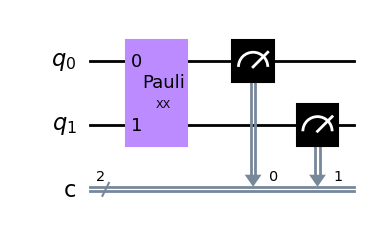

In [20]:
# Add to a circuit

qc2 = QuantumCircuit(2,2)
qc2.append(Pauli('XX'),[0,1])
qc2.measure([0,1],[0,1])
qc2.draw('mpl')

In [43]:
for index in np.ndindex(3,2,1):
    print(index)

(0, 0, 0)
(0, 1, 0)
(1, 0, 0)
(1, 1, 0)
(2, 0, 0)
(2, 1, 0)
